In [1]:
import os
import json
import gdown
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [2]:
# Load cached data
if not os.path.exists('../data'):
    gdown.download('https://drive.google.com/u/1/uc?id=1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK&export=download','../data.tar.gz')
    os.system('tar -xvf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
if not os.path.exists('../data/imagenet/human_readable_labels.json'):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

In [3]:
# Problem setup
n=1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage

In [4]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

In [5]:
# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = cal_smx.argsort(1)[:,::-1]; cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1).cumsum(axis=1)
cal_scores = np.take_along_axis(cal_srt,cal_pi.argsort(axis=1),axis=1)[range(n),cal_labels]
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
# Deploy (output=list of length n, each element is tensor of classes)
val_pi = val_smx.argsort(1)[:,::-1]; val_srt = np.take_along_axis(val_smx,val_pi,axis=1).cumsum(axis=1)
prediction_sets = np.take_along_axis(val_srt <= qhat,val_pi.argsort(axis=1),axis=1)

In [6]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.9002653061224489


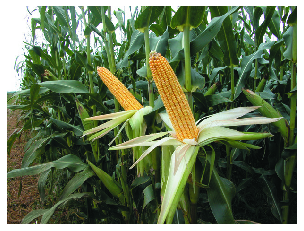

The prediction set is: ['corn', 'ear']


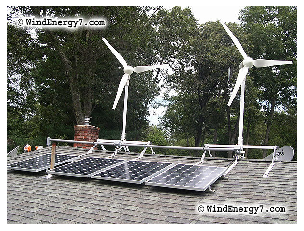

The prediction set is: ['folding chair', 'greenhouse', 'patio', 'radio telescope', 'solar thermal collector', 'sundial']


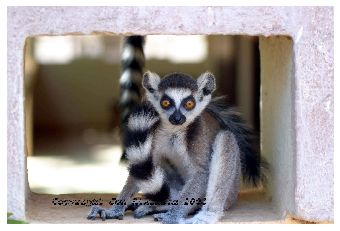

The prediction set is: ['ring-tailed lemur', 'indri']


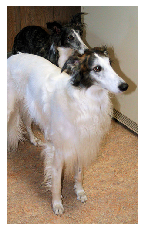

The prediction set is: ['borzoi', 'Saluki']


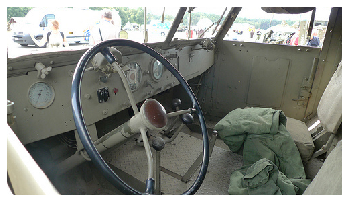

The prediction set is: ['great white shark', 'hammerhead shark', 'ostrich', 'vulture', 'koala', 'Dungeness crab', 'dugong', 'Greater Swiss Mountain Dog', 'Dalmatian', 'pug', 'Newfoundland', 'Pyrenean Mountain Dog', 'ant', 'baboon', 'sturgeon', 'aircraft carrier', 'airliner', 'ambulance', 'amphibious vehicle', 'analog clock', 'waste container', 'assault rifle', 'banjo', 'baluster', 'barber chair', 'wheelbarrow', 'bassinet', 'station wagon', 'tandem bicycle', 'binoculars', 'bra', 'bucket', 'taxicab', 'cauldron', 'cannon', 'canoe', 'car mirror', 'carousel', 'car wheel', 'cassette player', 'CD player', 'chain', 'chain-link fence', 'coil', 'convertible', 'cornet', 'cradle', 'Crock Pot', 'crutch', 'desk', 'rotary dial telephone', 'digital clock', 'dishwasher', 'disc brake', 'dock', 'Dutch oven', 'electric fan', 'electric locomotive', 'fireboat', 'fire engine', 'football helmet', 'forklift', 'freight car', 'French horn', 'frying pan', 'garbage truck', 'gas pump', 'golf cart', 'grille', 'guill

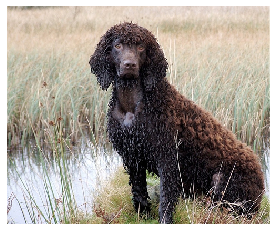

The prediction set is: ['Curly-coated Retriever', 'Sussex Spaniel', 'Irish Water Spaniel', 'Miniature Poodle', 'Standard Poodle']


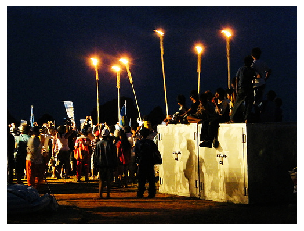

The prediction set is: ['academic gown', 'altar', 'military cap', 'bow', 'candle', 'cannon', 'cornet', 'dock', 'drum', 'drumstick', 'flagpole', 'lighter', 'match', 'military uniform', 'square academic cap', 'plunger', 'pole', 'rifle', 'shield', 'spotlight', 'stage', 'torch', 'vestment']


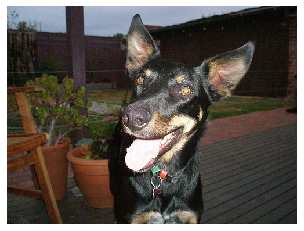

The prediction set is: ['Australian Kelpie', 'Rottweiler', 'Dobermann', 'Miniature Pinscher']


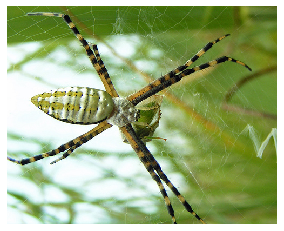

The prediction set is: ['yellow garden spider', 'barn spider', 'European garden spider', 'wolf spider', 'dragonfly', 'spider web']


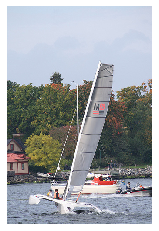

The prediction set is: ['catamaran', 'schooner', 'trimaran', 'yawl']


In [7]:
# Show some examples
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    prediction_set = smx[img_index] > 1-qhat
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")